# **Machine learning engineer nanodegree**

## **Facial expression recognition**

### **Problem statement**
One of the non-verbal communication methods by which one can understand the emotional state of a person is the expression of his face. As the technology runs our lives these days, the majority of our time is spent in interacting with computers and mobile phones in our daily lives. Therefore, Adding facial expression recognition feature to our devices to expect the user’s emotional state can improve human-computer interaction. 


The goal of this project is to apply deep learning techniques to recognize the key seven human emotions: anger, disgust, fear, happiness, sadness, surprise and neutrality.

In this project, the dataset we will use is Kaggle’s Facial Expression Recognition
Challenge dataset. This dataset is representative because of its size, unstructured nature of faces and relatively uniform distribution of the data across the seven main human emotions. 
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

## **The Road Ahead**
 ***The notebook is broken into separate steps as shown below:***

1.   Exploratory data analysis.
2.   Data preprocessing.
3.   Model building.
4.   Model training.
5.   Results.
6.   Benchmark model creating.











In [0]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

### **1. Exploratory data analysis**

**Importing Kaggle dataset**

In the cells below, we download Kaggle dataset into google colab 
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"olahamdy","key":"1f8162acc298d2029479bba677dbdc82"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

**Extract our tar file**

In [0]:
import tarfile
tf = tarfile.open("fer2013.tar.gz")
tf.extractall()

### **Data Exploration**

In the cells below, We need to explore our dataset and see its distribution over our labels


In [0]:
dataset = pd.read_csv('fer2013/fer2013.csv')
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


#### **Bar plot of the data distribution** 

The plot below shows the data distribution over the whole dataset, This plot is the most suitable one to start with as it is simple and easy to understand. It also gives valuable information on how the values are distributed.

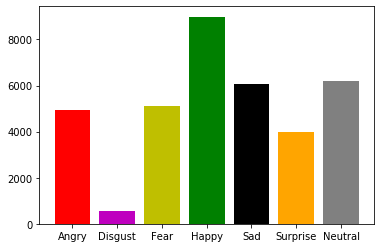


 Image Counts
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [0]:
train_df = dataset[dataset["Usage"]=="Training"]
valid_df = dataset[dataset["Usage"]=="PublicTest"]
test_df = dataset[dataset["Usage"]=="PrivateTest"]

all_data = dataset.groupby("emotion").size()
train_data = train_df.groupby("emotion").size()
test_data = test_df.groupby("emotion").size()
valid_data = valid_df.groupby("emotion").size()

labels = list(range(0, 7))
em_list = ["Angry","Disgust","Fear", "Happy", "Sad", "Surprise", "Neutral"]
colors = ["R", "M", "y", "g", "black", "orange", "grey"]
plt.bar(em_list, height= [all_data[i] for i in labels], color=colors)
plt.show()


print("\n Image Counts")
print(dataset['emotion'].value_counts())

The plot below show the distribution of the data in training, validation and testing sets, each emotion has a numeric code from 0 to 6 that represents the emotion of the image (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

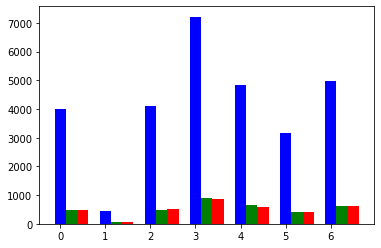

In [0]:
X = np.arange(7)
plt.bar(X + 0.00, train_data, color = 'b', width = 0.25)
plt.bar(X + 0.25, valid_data, color = 'g', width = 0.25)
plt.bar(X + 0.50, test_data, color = 'r', width = 0.25)

plt.show()

## **2. Data preprocessing**

For the “pixels” column, it contains a string for each image, This string consists of space-separated pixel values in row major order.

For the “emotions” column, it contains a numeric code from 0 to 6 that represents the emotion of the image  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

So, To feed the neural network with the inputs we need to reshape them into 48x48x1 numpy arrays, and the emotions value will be converted into categorical values such that each emotion will be represented as 1x7 vector.


In [0]:
Xstr_train = train_df["pixels"].values
Xstr_valid = valid_df["pixels"].values
Xstr_test = test_df["pixels"].values

y_train = train_df["emotion"].values
y_valid= valid_df["emotion"].values
y_test= test_df["emotion"].values

X_train = []
for x in Xstr_train:
	x_list = [float(i) for i in x.split()]
	X_train.append(x_list)

X_valid = []
for x in Xstr_valid:
	x_list = [float(i) for i in x.split()]
	X_valid.append(x_list)
 
X_test = []
for x in Xstr_test:
	x_list = [float(i) for i in x.split()]
	X_test.append(x_list)


X_train_pre = np.array(X_train)
X_valid_pre = np.array(X_valid)
X_test_pre = np.array(X_test)

y_train_pre = np.array(y_train)
y_valid_pre = np.array(y_valid)
y_test_pre = np.array(y_test)


In [0]:
print(y_train_pre.shape[0])
print(y_test_pre.shape[0])
print(y_valid_pre.shape[0])

28709
3589
3589


In [0]:
X_train = np.reshape(X_train_pre,(X_train_pre.shape[0],48,48,1))
X_valid = np.reshape(X_valid_pre,(X_valid_pre.shape[0],48,48,1))
X_test = np.reshape(X_test_pre,(X_test_pre.shape[0],48,48,1))

X_train /= 255
X_valid/= 255
X_test/= 255

num_classes = len (np.unique(y_train_pre))
y_train = to_categorical(y_train_pre,num_classes)
y_valid = to_categorical(y_valid_pre,num_classes)
y_test = to_categorical(y_test_pre,num_classes)
print ("Number of classs: ",num_classes)

Number of classs:  7


## **3. Model building**

 CNN is the state-of-art algorithm for most image processing tasks including classification. It can be thought of automatic feature extractor from the image, It works really well when the order of the features is important, and this is exactly the case with images. The numeric representation of the image pixels are our features, and the order of pixels is very significant.

Since our problem is to expect a facial expression in an image, we’ve decided to use CNN implemented in Keras library with a Tensorflow backend. We’ve used keras as it offers a great balance between simplicity and efficiency.

*   A simple CNN is created to classify images. It consists of six convolutional layers with three max pooling layers in between (one after each 2 ConvLayers).

*   Filters were increased from 32 to 128 and dropout was added.
*   Relu was used as an activation function for the hidden layers.
*   Flattening layer along with two fully connected layers were added at the end of the network.
*   Last layer used softmax as the activation function with seven nodes for our seven labels.

In [0]:
#Model Initialization
model = Sequential() 

#Adding Input Layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48,48,1)))

#Adding more layers
model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Flattening
model.add(Flatten())

#Adding fully connected layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3)) #
model.add(Dense(512, activation='relu')) #
model.add(Dropout(0.4))

#Adding Output Layer
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)       

## **4. Model training**



*   The model is compiled using ‘adam’ as the optimizer and ‘categorical_crossentropy’ as the loss function.
*   Data augmentation is applied on the images of the training set  like shifting, mirroring,rotating and zooming, so that the model is more generalized for more features of images (non-overfitted).

*   The model is trained on 200 epochs with a batch size of 256. In addition, training and validation datasets are provided. Therefore, While training the model is able to validate itself against validation dataset in every single iteration.

*   During training, the weights that results the best validation accuracy is saved using “ModelCheckPoint”, in order to achieve best results.






In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

In [0]:
train_datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')



checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5',  monitor='val_acc', verbose=1, save_best_only=True, mode='max')
batch_size=256
epochs=200
history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(X_valid, y_valid),
                    validation_steps=X_valid.shape[0] // batch_size)

Epoch 1/200
 - 13s - loss: 1.8218 - acc: 0.2443 - val_loss: 1.7979 - val_acc: 0.2494

Epoch 00001: val_acc improved from -inf to 0.24937, saving model to aug_model.weights.best.hdf5
Epoch 2/200
 - 12s - loss: 1.7968 - acc: 0.2495 - val_loss: 1.7773 - val_acc: 0.2421

Epoch 00002: val_acc did not improve from 0.24937
Epoch 3/200
 - 12s - loss: 1.7842 - acc: 0.2523 - val_loss: 1.7941 - val_acc: 0.2675

Epoch 00003: val_acc improved from 0.24937 to 0.26748, saving model to aug_model.weights.best.hdf5
Epoch 4/200
 - 12s - loss: 1.7737 - acc: 0.2605 - val_loss: 1.7134 - val_acc: 0.3093

Epoch 00004: val_acc improved from 0.26748 to 0.30928, saving model to aug_model.weights.best.hdf5
Epoch 5/200
 - 12s - loss: 1.7334 - acc: 0.2864 - val_loss: 1.6485 - val_acc: 0.3360

Epoch 00005: val_acc improved from 0.30928 to 0.33603, saving model to aug_model.weights.best.hdf5
Epoch 6/200
 - 13s - loss: 1.6909 - acc: 0.3180 - val_loss: 1.5563 - val_acc: 0.3993

Epoch 00006: val_acc improved from 0.3360

##### **Loading the model with best validation accuracy**

In [0]:
model.load_weights('aug_model.weights.best.hdf5')

In [0]:
from google.colab import files
files.download('aug_model.weights.best.hdf5') 

## **5. Results**

The plotting below shows us a the accuracy curves of training set and validation set while training, to make sure that the model generalizes well (doesn’t overfit) and it uses the data in the best possible way (doesn’t underfit). 

Text(0.5, 1.0, 'Accuracy Curves')

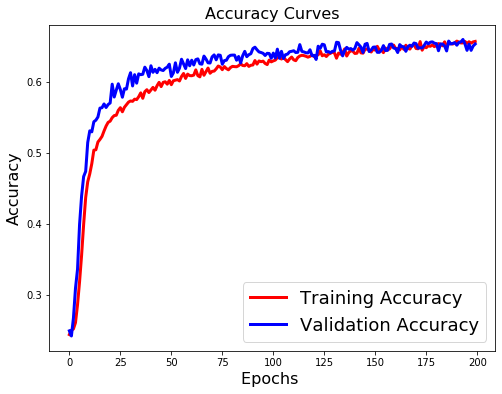

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


In [0]:
accuracy=model.evaluate(X_test,y_test)
print("Testing accuracy= ",accuracy[1])

3589/3589 [==============================] - 0s 109us/step
Testing accuracy=  0.67205349682898


In [0]:
files.upload()

Saving sad2.jpg to sad2.jpg


{'sad2.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x02\x01,\x01,\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0crTRC\x0

#### **Predicting new images**
To predict the label of an image, it is first reshaped to 48x48 grayscale image to meet the requirements of the model, and then, its pixel values are divided by 255, so that, it ranges 0-1.

In [0]:
from keras.preprocessing import image

def load_predict(addr,true_emo):

  img = image.load_img(addr, color_mode = "grayscale", target_size=(48, 48))
  plt.imshow(img)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img/=255.0
  classes = model.predict(img)
  pred_idx = np.argmax(classes)
  labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
  print('The predicted label is ',labels[pred_idx],",The true label is ", true_emo)

The predicted label is  angry ,The true label is  angry


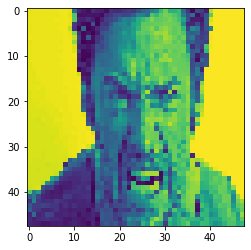

In [0]:
load_predict('angry.jpg','angry')

The predicted label is  happy ,The true label is  happy


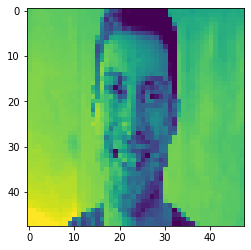

In [0]:
load_predict('happy.png','happy')


The predicted label is  sad ,The true label is  sad


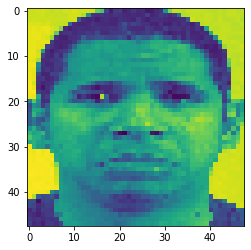

In [0]:
load_predict('sad.jpg','sad')


The predicted label is  fear ,The true label is  surprise


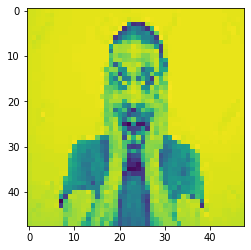

In [0]:
load_predict('surprise.jpeg','surprise')


The predicted label is  fear ,The true label is  fear


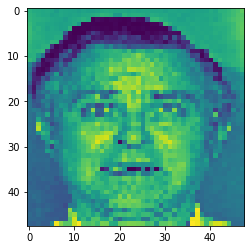

In [0]:
load_predict('fear.jpg','fear')

The predicted label is  sad ,The true label is  disgust


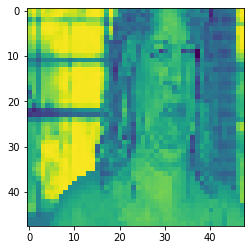

In [0]:
load_predict('disgust.jpg','disgust')

## **6. Benchmark model**
Support Vector Machine SVM is used as a benchmark model. SVMs have been widely applied to machine vision fields such as character, handwriting digit and text recognition, and more recently to satellite image classification. It is interesting to compare our results with a wide-scoped machine learning algorithm like SVM. 

In [0]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_pre,y_train_pre)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

We can expect for CNN to have higher accuracy than the general algorithm. If this assumption is confirmed, we can conclude that, when it comes to image recognition we should give preference to more specialized algorithm in that domain.

In [0]:
from sklearn.metrics import accuracy_score
y_predicted = clf.predict(X_test_pre)
accuracy = accuracy_score(y_test_pre, y_predicted)
print("Testing accuracy= ",accuracy)

y_predicted = clf.predict(X_train_pre)
accuracy = accuracy_score(y_train_pre, y_predicted)
print("Training accuracy= ",accuracy)

Testing accuracy=  0.36834772917247144
Training accuracy=  0.377059458706329
